In [12]:
import functools

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torchsummary import summary


def load_CIFAR10_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                             download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set,
                                                  (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                            download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=4096,
                                   shuffle=True, num_workers=0)
    validation_loader = data.DataLoader(validation_set, batch_size=4096,
                                        shuffle=True, num_workers=0)
    test_loader = data.DataLoader(test_set, batch_size=4096,
                                  shuffle=True, num_workers=0)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return train_loader, validation_loader, test_loader, classes


def load_CIFAR100_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR100(root='./dataset', train=True,
                                              download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set, (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR100(root='./dataset', train=False,
                                             download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=1024,
                                   shuffle=True, num_workers=2)
    validation_loader = data.DataLoader(validation_set, batch_size=1024,
                                        shuffle=True, num_workers=2)
    test_loader = data.DataLoader(test_set, batch_size=1024,
                                  shuffle=True, num_workers=2)

    return train_loader, validation_loader, test_loader


def num_flat_features(x):
    return functools.reduce(lambda a, b: a * b, x.size()[1:])


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def accuracy_plot(train_accuracies, accuracies, TEST):
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies)
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.xlabel("epoch")
    plt.ylabel("accuracy\n(%)").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])
    plt.show()


def losses_plot(train_losses, losses, TEST):
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel("epoch")
    plt.ylabel("loss").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])


def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    correct = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        regularization_loss = 0.0
        for param in model.parameters():
            regularization_loss += torch.norm(param)
        loss = criterion(outputs, y) + LAMBDA * regularization_loss
        loss.backward()
        optimizer.step()
        outputs = F.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()
    train_percentage = round(correct / len(train_loader.dataset) * 100, 2)
    print(f"Epoch:{epoch} Train Accuracy:{correct}/{len(train_loader.dataset)} ({train_percentage}%)")
    return train_percentage, loss.item()


def validate(model, validation_loader, criterion, device, epoch):
    model.eval()
    vali_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in validation_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            vali_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    vali_loss /= len(validation_loader.dataset)
    vali_percentage = round(correct / len(validation_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Validation loss: {vali_loss:0.6f}, Validation Accuracy:{correct}/{len(validation_loader.dataset)} ({vali_percentage}%)"
    )
    return vali_percentage, vali_loss


def test(model, test_loader, criterion, device, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            test_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_percentage = round(correct / len(test_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Test loss: {test_loss:0.6f}, Test Accuracy:{correct}/{len(test_loader.dataset)} ({test_percentage}%)"
    )
    return test_percentage, test_loss


class convLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, pooling_size):
        super(convLayer, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size)
        self.pooling_size = pooling_size
        if self.pooling_size:
            self.pool = nn.MaxPool2d(pooling_size)
        self.bm = nn.BatchNorm2d(out_channel)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bm(x)
        if self.pooling_size:
            x = self.pool(x)
        x = self.drop(x)
        return x


# https://discuss.pytorch.org/t/flatten-layer-of-pytorch-build-by-sequential-container/5983
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = convLayer(3, 32, 3, 2)
        self.conv2 = convLayer(32, 64, 5, 0)
        self.conv3 = convLayer(64, 128, 5, 2)
        self.conv4 = convLayer(128, 256, 5, 2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(7744, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.layers = [self.conv1, self.conv2, self.flatten, self.fc1, self.fc2, self.fc3]
        self.activations = [False, False, False, False, False, True, True, True]

    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            if activation:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, validation_loader, test_loader, classes = load_CIFAR10_data()

Files already downloaded and verified
Files already downloaded and verified


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
         MaxPool2d-3           [-1, 32, 15, 15]               0
           Dropout-4           [-1, 32, 15, 15]               0
         convLayer-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 11, 11]          51,264
       BatchNorm2d-7           [-1, 64, 11, 11]             128
           Dropout-8           [-1, 64, 11, 11]               0
         convLayer-9           [-1, 64, 11, 11]               0
          Flatten-10                 [-1, 7744]               0
           Linear-11                 [-1, 4096]      31,723,520
           Linear-12                 [-1, 1024]       4,195,328
           Linear-13                   [-1, 10]          10,250
Total params: 35,981,450
Trainable para

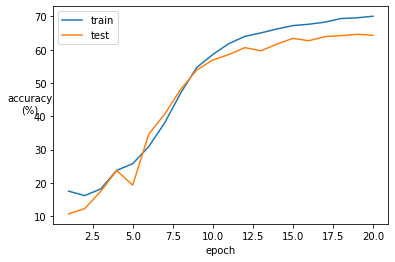

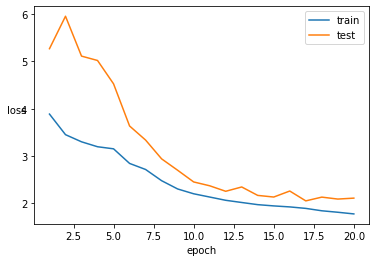

In [13]:
EPOCH = 20
TEST = True
LAMBDA = 0.01

model = CIFAR10Model()
model.to(device)

summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_accuracies = []
accuracies = []
train_losses = []
losses = []
for epoch in range(1, EPOCH + 1):
    acc, loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_accuracies.append(acc)
    train_losses.append(loss)
    if not TEST:
        acc, loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(train_accuracies, accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

In [ ]:
for epoch in range(1, EPOCH + 1):
    acc, loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_accuracies.append(acc)
    train_losses.append(loss)
    if not TEST:
        acc, loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(train_accuracies, accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

Epoch:1 Train Accuracy:31742/45000 (70.54%)
Epoch:1 Test loss: 1.966606, Test Accuracy:3277/5000 (65.54%)
Epoch:2 Train Accuracy:32097/45000 (71.33%)
Epoch:2 Test loss: 2.072910, Test Accuracy:3266/5000 (65.32%)
Epoch:3 Train Accuracy:32184/45000 (71.52%)
Epoch:3 Test loss: 2.032160, Test Accuracy:3349/5000 (66.98%)
Epoch:4 Train Accuracy:32405/45000 (72.01%)
Epoch:4 Test loss: 1.941020, Test Accuracy:3333/5000 (66.66%)
Epoch:5 Train Accuracy:32573/45000 (72.38%)
Epoch:5 Test loss: 2.059958, Test Accuracy:3293/5000 (65.86%)
Epoch:6 Train Accuracy:32817/45000 (72.93%)
Epoch:6 Test loss: 1.915702, Test Accuracy:3330/5000 (66.6%)
Epoch:7 Train Accuracy:33059/45000 (73.46%)
Epoch:7 Test loss: 1.910477, Test Accuracy:3374/5000 (67.48%)
Epoch:8 Train Accuracy:33006/45000 (73.35%)
Epoch:8 Test loss: 1.942979, Test Accuracy:3332/5000 (66.64%)
Epoch:9 Train Accuracy:33087/45000 (73.53%)
Epoch:9 Test loss: 1.867897, Test Accuracy:3380/5000 (67.6%)
Epoch:10 Train Accuracy:33340/45000 (74.09%)
Epo